# **Thông tin nhóm**
## Mã nhóm: 20CQ.PTDL.05
## Danh sách thành viên:
*   20120466 - Trần Thị Thu Hà
*   20120592 - Lê Minh Tiến
*   20120595 - Phạm Minh Tiến
*   20120624 - Mai Quyết Vang



# Thêm thư viện cần thiết

In [261]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

Load dữ liệu

In [262]:
link_p1 = "https://raw.githubusercontent.com/Vanniee007/ADA-Final-Project-20CQ.PTDL.05/main/data/Data_Train_p1.xlsx"
link_p2 = "https://raw.githubusercontent.com/Vanniee007/ADA-Final-Project-20CQ.PTDL.05/main/data/Data_Train_p2.xlsx"


In [263]:
# Đọc dữ liệu từ file Excel
Data_Train_p1 = pd.read_excel(link_p1)
Data_Train_p2 = pd.read_excel(link_p2)

# Ghép nối hai DataFrame
merged_data = pd.concat([Data_Train_p1, Data_Train_p2], ignore_index=True)


# **Preprocessing**

## Xử lí duplicate: Xóa các dòng bị trùng lặp

In [264]:
# Kiểm tra duplicate data và sắp xếp theo cột để dòng trùng lặp gần nhau
duplicates = merged_data[merged_data.duplicated(keep=False)].sort_values(by=merged_data.columns.tolist())

if len(duplicates) > 0:
    print("Có {} dòng dữ liệu bị trùng lặp.".format(len(duplicates)))
    duplicates.to_excel('duplicate_data.xlsx', index=False)
else:
    print("Không có dòng dữ liệu trùng lặp.")
print("Số dòng dữ liệu trước khi xóa các dòng trùng lặp:")
print(merged_data.shape[0])


# Xóa các dòng dữ liệu bị trùng, chỉ giữ lại dòng có index nhỏ hơn (bên trên)
merged_data = merged_data.drop_duplicates(keep='first')
print("Số dòng dữ liệu sau khi xóa các dòng trùng lặp:")
print(merged_data.shape[0])

Có 417 dòng dữ liệu bị trùng lặp.
Số dòng dữ liệu trước khi xóa các dòng trùng lặp:
10684
Số dòng dữ liệu sau khi xóa các dòng trùng lặp:
10463


## Chuyển Duration thành phút (int): Chuyển đổi từ kiểu giờ-phút về kiểu int để tiện cho các tính toán bên dưới.


In [265]:
# Chuyển đổi cột 'Duration' về đơn vị phút
def convert_duration(duration):
    if 'h' in duration and 'm' in duration:
        return int(duration.split('h')[0]) * 60 + int(duration.split('h')[1].split('m')[0])
    elif 'h' in duration:
        return int(duration.split('h')[0]) * 60
    elif 'm' in duration:
        return int(duration.split('m')[0])
    else:
        return 0

merged_data['Duration'] = merged_data['Duration'].apply(convert_duration)


## Chuyển Total_stop thành kiểu int

In [266]:
# Chuyển Total_Stops về kiểu int, giữ lại giá trị null
merged_data['Total_Stops'] = merged_data['Total_Stops'].replace({'non-stop': 0, '1 stop': 1, '2 stops': 2, '3 stops': 3, '4 stops': 4, '': np.nan}).fillna('Blanks')

## Xử lí cột Date_of_Journey: xử lí thành cùng định dạng (dd/mm/yyyy)

In [267]:
merged_data['Date_of_Journey'] = pd.to_datetime(merged_data['Date_of_Journey'], format='%d/%m/%Y', errors='coerce')
merged_data['Month'] = merged_data['Date_of_Journey'].dt.month
merged_data['WeekDay'] = merged_data['Date_of_Journey'].dt.day_name()
#Appending weekend column
merged_data['Weekend'] = merged_data['WeekDay'].apply(lambda day: 1 if day == 'Sunday' else 0)
merged_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Month,WeekDay,Weekend
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,170,0.0,No info,3897,3,Sunday,1
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,445,2.0,No info,7662,5,Wednesday,0
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,1140,2.0,No info,13882,6,Sunday,1
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,325,1.0,No info,6218,5,Sunday,1
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,285,1.0,No info,13302,3,Friday,0


## Tính lại Arrival_Time, do có một vài Arrival_Time chưa chính xác, vì Arrival_Time phải bằng Dep_Time+ Duration (và còn phụ thuộc vào Date of Journey), nên tính lại Arrival_Time dựa vào 3 cột đó

In [268]:
# Hàm tùy chỉnh để xử lý ngày trong 'Arrival_Time'
def extract_arrival_day(row):
    date_of_journey = row['Date_of_Journey'].strftime('%Y-%m-%d')
    dep_time = row['Dep_Time'].strip()  # Strip extra spaces

    # Chuyển đổi Departure Time thành đối tượng datetime
    dep_datetime = datetime.strptime(str(date_of_journey) + ' ' + dep_time, '%Y-%m-%d %H:%M')

    # Tính thời gian di chuyển thành đối tượng timedelta
    duration_minutes =  row['Duration']
    travel_duration = timedelta(minutes=duration_minutes)

    # Tính thời gian đến (Arrival Time) bằng cách cộng thêm thời gian di chuyển vào Departure Time
    arrival_datetime = dep_datetime + travel_duration

    #Trả về ngày đến dưới dạng chuỗi 'dd/mm/yyyy'
    return arrival_datetime.strftime('%d/%m/%Y')


# Áp dụng hàm cho cột 'Arrival_Day'
merged_data['Arrival_Date'] = pd.to_datetime(merged_data.apply(extract_arrival_day, axis=1), format='%d/%m/%Y', errors='coerce')

merged_data['Arrival_Time'] = pd.to_datetime(merged_data['Arrival_Time']).dt.strftime('%H:%M')

merged_data.head()

C:\Users\Ha\AppData\Local\Temp\ipykernel_24524\3877452211.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_data['Arrival_Time'] = pd.to_datetime(merged_data['Arrival_Time']).dt.strftime('%H:%M')


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Month,WeekDay,Weekend,Arrival_Date
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10,170,0.0,No info,3897,3,Sunday,1,2019-03-25
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,445,2.0,No info,7662,5,Wednesday,0,2019-05-01
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25,1140,2.0,No info,13882,6,Sunday,1,2019-06-10
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,325,1.0,No info,6218,5,Sunday,1,2019-05-12
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,285,1.0,No info,13302,3,Friday,0,2019-03-01


## Xử lí outlier tại Duration: các outlier đều chấp nhận được bởi nó có 2-3 sân bay trung chuyển (total_stop), điều này có thể hiểu là chuyến bay xa, hoặc ở sân bay trung chuyển mất thời gian làm thủ tục, hoặc do các chuyến bay bị delay

### Tìm outlier

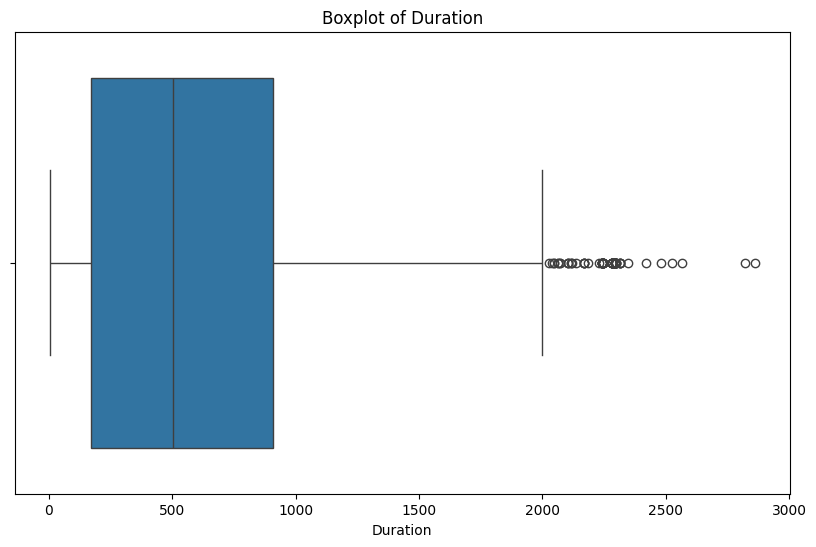

In [269]:
# Vẽ boxplot để phát hiện outlier
plt.figure(figsize=(10, 6))
sns.boxplot(x=merged_data['Duration'])
plt.title('Boxplot of Duration')
plt.show()

In [270]:
# Tìm giá trị Q1, Q3 và IQR của cột 'Duration'
Q1_duration = merged_data['Duration'].quantile(0.25)
Q3_duration = merged_data['Duration'].quantile(0.75)
IQR_duration = Q3_duration - Q1_duration

# Xác định ngưỡng cho outlier
lower_bound_duration = Q1_duration - 1.5 * IQR_duration
upper_bound_duration = Q3_duration + 1.5 * IQR_duration

# Lọc ra các dòng có giá trị 'Duration' là outlier
outliers_duration = merged_data[(merged_data['Duration'] < lower_bound_duration) | (merged_data['Duration'] > upper_bound_duration)]

# Sắp xếp các dòng outlier theo cột 'Duration' từ bé đến lớn
sorted_outliers_duration = outliers_duration.sort_values(by='Duration')

# Hiển thị DataFrame sau khi sắp xếp
sorted_outliers_duration.head(50)


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Month,WeekDay,Weekend,Arrival_Date
2747,Air India,2019-03-18,Banglore,New Delhi,BLR → BOM → UDR → DEL,06:45,16:30,2025,2.0,No info,10835,3,Monday,0,2019-03-19
1284,Jet Airways,2019-03-21,Delhi,Cochin,DEL → BDQ → BOM → COK,18:25,04:25,2040,2.0,No info,12347,3,Thursday,0,2019-03-23
8865,Jet Airways,2019-03-21,Delhi,Cochin,DEL → UDR → BOM → COK,18:20,04:25,2045,2.0,No info,13082,3,Thursday,0,2019-03-23
5758,Jet Airways,2019-03-03,Delhi,Cochin,DEL → UDR → BOM → COK,18:20,04:25,2045,2.0,No info,20747,3,Sunday,1,2019-03-05
1112,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → DEL → BLR,05:50,16:15,2065,2.0,No info,10991,5,Wednesday,0,2019-05-02
703,Air India,2019-05-15,Kolkata,Banglore,CCU → IXR → DEL → BLR,05:50,16:15,2065,2.0,No info,12723,5,Wednesday,0,2019-05-16
3193,Jet Airways,2019-03-06,Delhi,Cochin,DEL → UDR → BOM → COK,17:55,04:25,2070,2.0,In-flight meal not included,15812,3,Wednesday,0,2019-03-08
7322,Jet Airways,2019-03-06,Delhi,Cochin,DEL → UDR → BOM → COK,17:55,04:25,2070,2.0,No info,17072,3,Wednesday,0,2019-03-08
2917,Air India,2019-03-03,Banglore,New Delhi,BLR → CCU → GAU → DEL,11:05,22:10,2105,2.0,No info,11948,3,Sunday,1,2019-03-04
9386,Air India,2019-03-03,Banglore,New Delhi,BLR → CCU → GAU → DEL,11:05,22:10,2105,2.0,No info,11791,3,Sunday,1,2019-03-04


### Xóa dòng đặc biệt ở Duration: có 1 dòng Duration = 5 phút, 1 chuyến bay thì không thể kéo dài 5p được -> xóa.

In [271]:
# Xóa các dòng có giá trị 'Duration' bằng 5
merged_data = merged_data[merged_data['Duration'] != 5]




# **Quan sát và phân tích tập dữ liệu (EDA)**


## 1. Cho biết kiểu dữ liệu của các thuộc tính


In [272]:
# Hiển thị thông tin về DataFrame
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10462 entries, 0 to 10682
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Airline          10462 non-null  object        
 1   Date_of_Journey  10462 non-null  datetime64[ns]
 2   Source           10462 non-null  object        
 3   Destination      10462 non-null  object        
 4   Route            10461 non-null  object        
 5   Dep_Time         10462 non-null  object        
 6   Arrival_Time     10462 non-null  object        
 7   Duration         10462 non-null  int64         
 8   Total_Stops      10462 non-null  object        
 9   Additional_Info  10462 non-null  object        
 10  Price            10462 non-null  int64         
 11  Month            10462 non-null  int32         
 12  WeekDay          10462 non-null  object        
 13  Weekend          10462 non-null  int64         
 14  Arrival_Date     10462 non-null  datetime64

## 2. Đối với cột Price, cho biết:


*   Giá cao nhất, thấp nhất, giá trung bình, mức giá xuất hiện nhiều
*   Độ lệch chuẩn của cột price?
*   Cho biết giá phân phối xung quanh trung tâm hay cách xa trung tâm?
Nhận xét về giá trị mean và median của tập dữ liệu.
*   Vẽ đồ thị histogram để nhận xét dữ liệu có bị lệch không?
List item





### 2.1 Code

Giá cao nhất: 79512
Giá thấp nhất: 1759
Giá trung bình: 9025.849072835023
Mức giá xuất hiện nhiều nhất: 10262
Số lần xuất hiện của mức giá: 258
Độ lệch chuẩn của cột Price: 4624.162124562484
Mean: 9025.849072835023, Median: 8266.0
Giá trị mean lớn hơn median, dữ liệu lệch về bên phải.


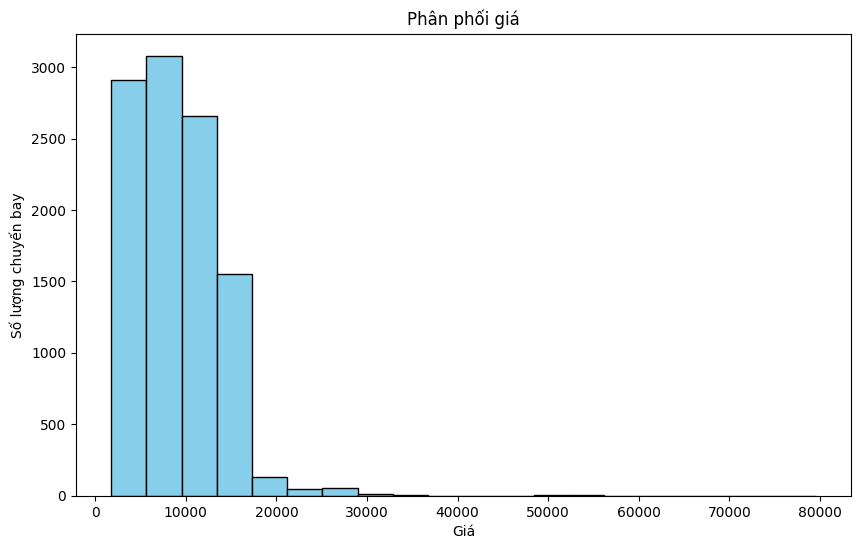

In [273]:
# 1. Giá cao nhất, thấp nhất, giá trung bình, mức giá xuất hiện nhiều
max_price = merged_data['Price'].max()
min_price = merged_data['Price'].min()
mean_price = merged_data['Price'].mean()
# Đếm số lần xuất hiện của từng giá trị
price_counts = merged_data['Price'].value_counts()
# Lấy giá trị mode (xuất hiện nhiều nhất)
mode_price = price_counts.idxmax()
# Số lần xuất hiện của giá trị mode
mode_count = price_counts.max()


print(f"Giá cao nhất: {max_price}")
print(f"Giá thấp nhất: {min_price}")
print(f"Giá trung bình: {mean_price}")
print(f"Mức giá xuất hiện nhiều nhất: {mode_price}")
print(f"Số lần xuất hiện của mức giá: {mode_count}")

# 2. Độ lệch chuẩn của cột Price
std_price = merged_data['Price'].std()
print(f"Độ lệch chuẩn của cột Price: {std_price}")

# 3. Nhận xét về giá trị mean và median của tập dữ liệu
median_price = merged_data['Price'].median()
print(f"Mean: {mean_price}, Median: {median_price}")
if mean_price > median_price:
    print("Giá trị mean lớn hơn median, dữ liệu lệch về bên phải.")
elif mean_price < median_price:
    print("Giá trị mean nhỏ hơn median, dữ liệu lệch về bên trái.")
else:
    print("Giá trị mean bằng median, phân phối đối xứng.")

# 4. Vẽ đồ thị histogram để nhận xét dữ liệu có bị lệch không
plt.figure(figsize=(10, 6))
plt.hist(merged_data['Price'], bins=20, color='skyblue', edgecolor='black')
plt.title('Phân phối giá')
plt.xlabel('Giá')
plt.ylabel('Số lượng chuyến bay')
plt.show()

### 2.2. Kết luận
#### - Giá cao nhất, thấp nhất, giá trung bình, mức giá xuất hiện nhiều
- Giá cao nhất: 79512
- Giá thấp nhất: 1759
- Giá trung bình: 9025.849072835023
- Mức giá xuất hiện nhiều nhất: 10262, Số lần xuất hiện của mức giá: 258
#### - Độ lệch chuẩn của cột price?
Độ lệch chuẩn của cột Price: 4624.162124562484

#### - Cho biết giá phân phối xung quanh trung tâm hay cách xa trung tâm? Nhận xét về giá trị mean và median của tập dữ liệu.
Giá trị mean lớn hơn median, dữ liệu lệch về bên phải. Điều này chứng tỏ có một số giá trị lớn ở phía bên phải của phân phối nghĩa là có các chuyến bay có giá vé cao.
#### - Vẽ đồ thị histogram để nhận xét dữ liệu có bị lệch không?
- Phần lớn chuyến bay có giá vé tập trung ở mức giá thấp: Có thể có một số lượng lớn chuyến bay có giá vé thấp, và đây là một đặc điểm chính của dữ liệu.
- Có một số chuyến bay có giá vé cao: Tuy nhiên, cũng có một số chuyến bay có giá vé cao hơn so với giá trung bình, nhưng chúng là ít hơn và tập trung ở khoảng giá trị cao hơn.
- Dữ liệu có độ biến động lớn: Sự chênh lệch giữa giá vé thấp và giá vé cao có thể làm cho phương sai (variance) của dữ liệu lớn.
- Phân phối lệch phải: Nếu phần lớn giá trị tập trung ở giá vé thấp, trong khi một số giá trị cao hơn được giữ lại, thì dữ liệu có thể có sự lệch phải.
- Ưu điểm: Các chuyến bay giá rẻ thường chiếm số lượng lớn, trong khi một số chuyến bay đắt tiền có thể là những trường hợp đặc biệt.

## 3. Mô tả số lượng missing value của mỗi thuộc tính


In [274]:
# 3. Mô tả số lượng missing value của mỗi thuộc tính
missing_values = merged_data.isnull().sum()
print("Số lượng missing value của mỗi thuộc tính:")
print(missing_values)

Số lượng missing value của mỗi thuộc tính:
Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
Month              0
WeekDay            0
Weekend            0
Arrival_Date       0
dtype: int64


## 4. Tính tỷ lệ % missing value của mỗi thuộc tính


In [275]:
# 4. Tính tỷ lệ % missing value của mỗi thuộc tính
missing_percentage = (missing_values / len(merged_data)) * 100
print("Tỷ lệ % missing value của mỗi thuộc tính:")
print(missing_percentage)

Tỷ lệ % missing value của mỗi thuộc tính:
Airline            0.000000
Date_of_Journey    0.000000
Source             0.000000
Destination        0.000000
Route              0.009558
Dep_Time           0.000000
Arrival_Time       0.000000
Duration           0.000000
Total_Stops        0.000000
Additional_Info    0.000000
Price              0.000000
Month              0.000000
WeekDay            0.000000
Weekend            0.000000
Arrival_Date       0.000000
dtype: float64


## 5. Xử lý dữ liệu missing


In [276]:
# 5. Xử lý dữ liệu missing ( xóa các dòng có missing value)
merged_data.dropna(subset=['Total_Stops'], inplace=True)
# drop null values
merged_data.dropna(axis=0, subset=['Total_Stops', 'Route'], inplace=True)
# reset indexes
merged_data.reset_index(inplace=True)
merged_data.drop(['index'], axis=1, inplace=True)

## 6. Outlier: sử dụng đồ thị boxplot để quan sát cột Price có tồn tại outlier không?

### Đồ thị

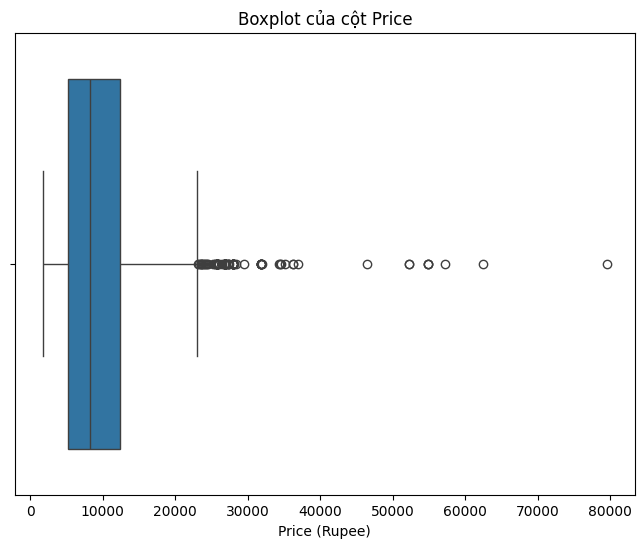

In [277]:
# Vẽ boxplot cho cột Price trong merged_data
plt.figure(figsize=(8, 6))
sns.boxplot(x=merged_data['Price'])
plt.title('Boxplot của cột Price')
plt.xlabel('Price (Rupee)')  # Thêm đơn vị cho trục x
plt.show()

### Các giá trị outlier: các giá trị outlier là có tồn tại, tuy nhiên có các chuyến bay giá cao như vậy có thể là do thời gian bay dài (Duration), hạng vé business/premium (Airline)




In [278]:
# Xác định giá trị Q1, Q3 và IQR
Q1 = merged_data['Price'].quantile(0.25)
Q3 = merged_data['Price'].quantile(0.75)
IQR = Q3 - Q1

# Xác định ngưỡng cho outlier
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Lọc ra các dòng có giá trị 'Price' là outlier
outliers = merged_data[(merged_data['Price'] < lower_bound) | (merged_data['Price'] > upper_bound)]

# Hiển thị các dòng có giá 'Price' là outlier
print("Các dòng có giá 'Price' là outlier:")
outliers


Các dòng có giá 'Price' là outlier:


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Month,WeekDay,Weekend,Arrival_Date
123,Air India,2019-03-01,Delhi,Cochin,DEL → BOM → COK,23:00,19:15,1215,1.0,No info,27430,3,Friday,0,2019-03-02
396,Multiple carriers,2019-03-01,Delhi,Cochin,DEL → BOM → COK,12:50,19:15,385,1.0,No info,36983,3,Friday,0,2019-03-01
627,Jet Airways,2019-03-01,Banglore,New Delhi,BLR → BOM → DEL,16:55,07:40,885,1.0,1 Long layover,26890,3,Friday,0,2019-03-02
688,Jet Airways,2019-03-01,Banglore,New Delhi,BLR → BOM → DEL,16:55,10:25,1050,1.0,1 Long layover,25735,3,Friday,0,2019-03-02
750,Jet Airways,2019-03-18,Banglore,New Delhi,BLR → BOM → DEL,22:50,05:05,375,1.0,No info,54826,3,Monday,0,2019-03-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9978,Jet Airways,2019-03-01,Banglore,New Delhi,BLR → BOM → DEL,11:40,18:25,405,1.0,No info,26890,3,Friday,0,2019-03-01
10106,Jet Airways,2019-03-01,Banglore,New Delhi,BLR → BOM → DEL,16:55,08:15,920,1.0,No info,26890,3,Friday,0,2019-03-02
10238,Air India,2019-03-01,Banglore,New Delhi,BLR → BOM → BHO → DEL,08:50,09:25,1475,2.0,No info,25430,3,Friday,0,2019-03-02
10279,Jet Airways,2019-03-01,Banglore,New Delhi,BLR → BOM → DEL,14:05,19:10,305,1.0,No info,36235,3,Friday,0,2019-03-01


# **Visualize dữ liệu dạng bảng hoặc đồ thị**

## 1. Giá vé tăng khi nào?

### Giá vé tăng khi hãng thay đổi: khi chọn Jet Airways Business thì giá vé sẽ cao hơn so với các hãng khác

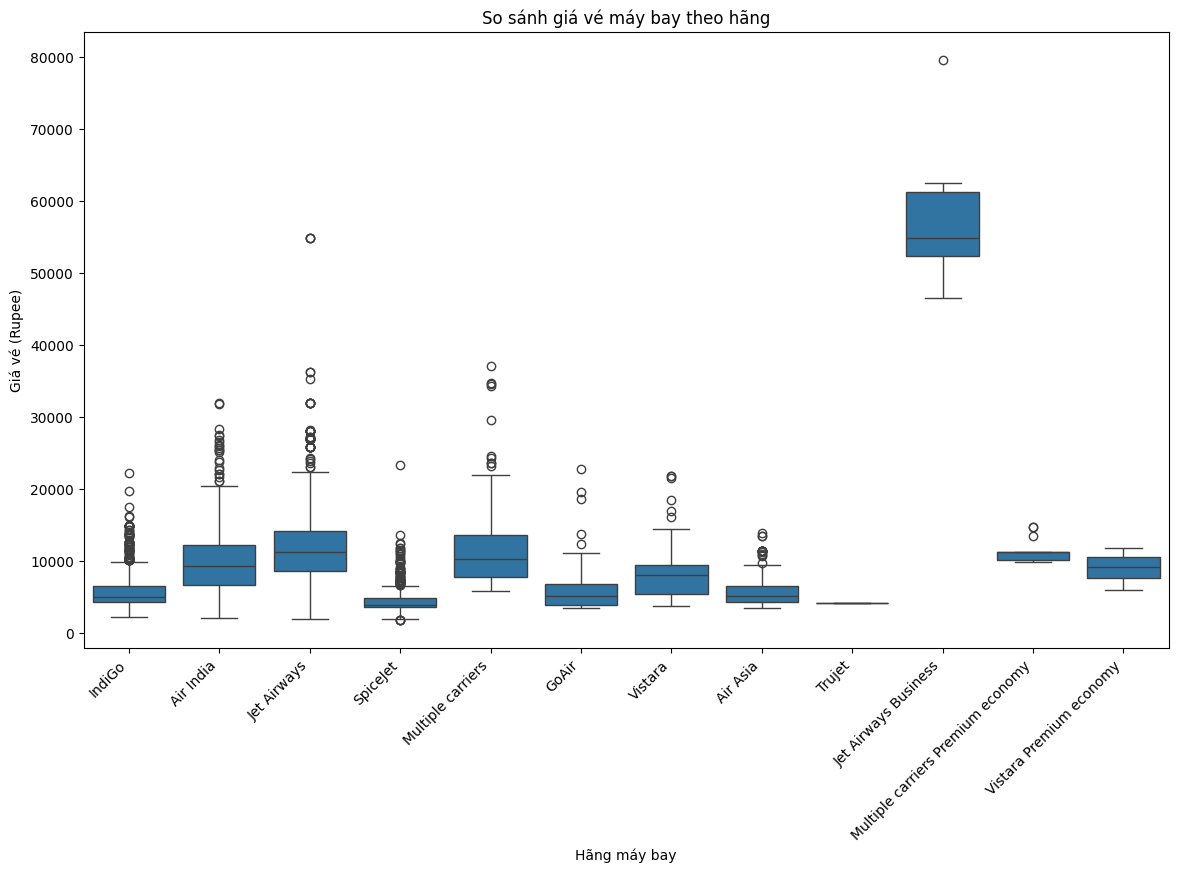

In [279]:
# Vẽ đồ thị so sánh giá vé theo hãng máy bay
plt.figure(figsize=(14, 8))
sns.boxplot(x='Airline', y='Price', data=merged_data)
plt.title('So sánh giá vé máy bay theo hãng')
plt.xlabel('Hãng máy bay')
plt.ylabel('Giá vé (Rupee)')
plt.xticks(rotation=45, ha='right')  # Để xác định định dạng các nhãn trên trục x
plt.show()


## 2. So sánh tỷ lệ các chuyến bay thẳng và trung chuyển (có dừng)

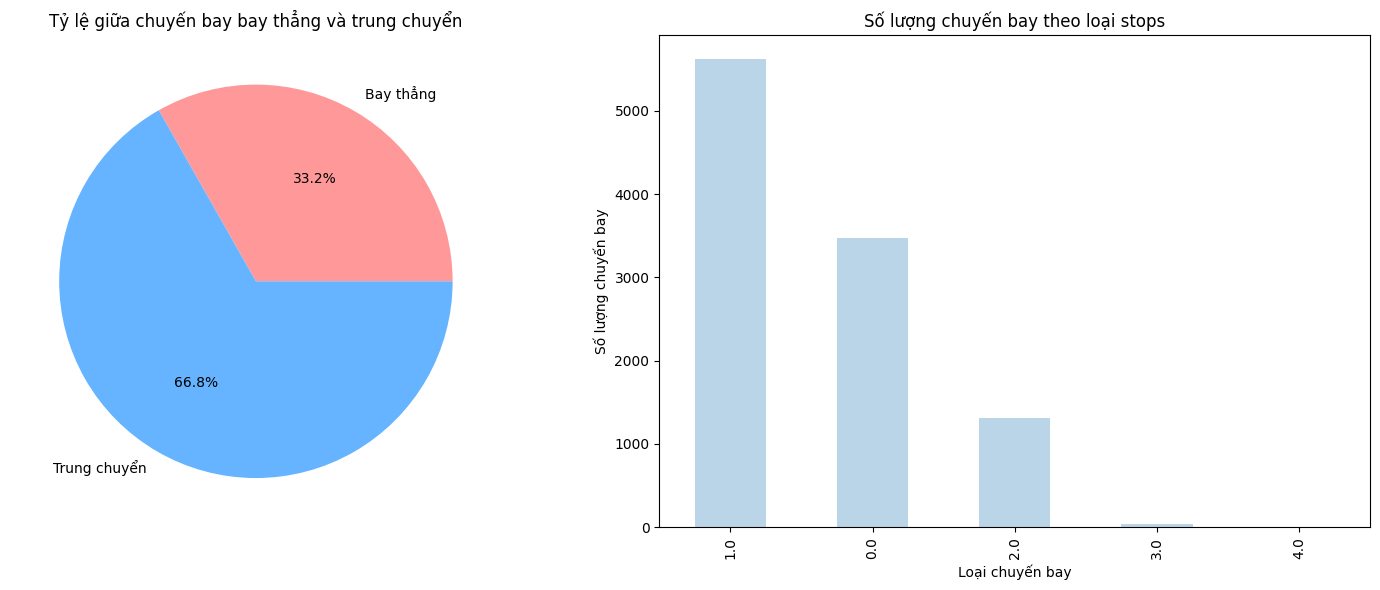

In [280]:
# Tạo DataFrame
data = pd.DataFrame(merged_data)

# Tính tỷ lệ giữa chuyến bay non-stop và chuyến bay có stops
stops_counts = data['Total_Stops'].value_counts()

# Tạo DataFrame mới chỉ chứa thông tin non-stop và stops
stops_data = pd.DataFrame({
    'Bay thẳng': stops_counts[0],
    'Trung chuyển': stops_counts.sum() - stops_counts[0]
}, index=[0])

# Vẽ biểu đồ
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Biểu đồ tròn cho tỷ lệ stops
colors_pie = ['#ff9999', '#66b3ff']  # Đổi màu ở đây
axes[0].pie(stops_data.iloc[0], labels=stops_data.columns, autopct='%1.1f%%', colors=colors_pie)
axes[0].set_title('Tỷ lệ giữa chuyến bay bay thẳng và trung chuyển')

# Biểu đồ cho tỷ lệ stops_counts
stops_counts.plot(kind='bar', alpha=0.3, ax=axes[1])
axes[1].set_title('Số lượng chuyến bay theo loại stops')
axes[1].set_xlabel('Loại chuyến bay')
axes[1].set_ylabel('Số lượng chuyến bay')

plt.tight_layout()
plt.show()

**Nhận xét:**
- Các chuyến bay trung chuyển nhiều gấp đôi những chuyến bay thẳng, đa số là một điểm dừng và ít hơn là 2 điểm dừng, từ 3 tới 4 là rất ít


## 3. Nước nào có lượng chuyến bay nhiều nhất?

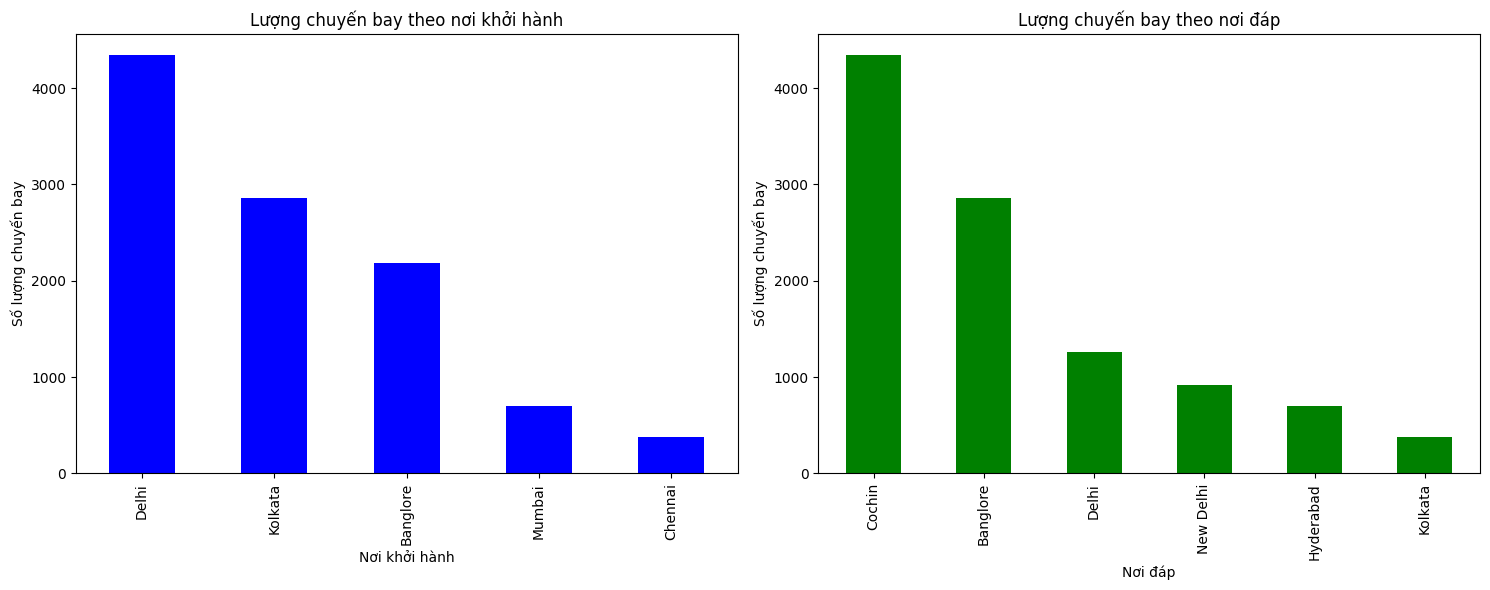

In [281]:
# Tạo DataFrame
data = pd.DataFrame(merged_data)

# Tạo subplot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Biểu đồ theo nơi khởi hành
flight_count_by_source = data['Source'].value_counts()
flight_count_by_source.plot(kind='bar', color='blue', ax=axes[0])
axes[0].set_title('Lượng chuyến bay theo nơi khởi hành')
axes[0].set_xlabel('Nơi khởi hành')
axes[0].set_ylabel('Số lượng chuyến bay')

# Biểu đồ theo nơi đáp
flight_count_by_destination = data['Destination'].value_counts()
flight_count_by_destination.plot(kind='bar', color='green', ax=axes[1])
axes[1].set_title('Lượng chuyến bay theo nơi đáp')
axes[1].set_xlabel('Nơi đáp')
axes[1].set_ylabel('Số lượng chuyến bay')

plt.tight_layout()
plt.show()

**Nhận xét:**
- Xét theo nơi khởi hành thì Delhi là thành phố có nhiều chuyến bay đi nhất.
- Xét theo nơi đáp thì Cochin là thành phố có nhiều chuyến bay đáp đến nhất.


## 4. Hãng máy bay nào được khách đặt vé nhiều/thấp nhất?

### 4.1 Visualize: Bởi vì cần đưa ra sự so sánh giữa các nhóm (các hãng mới bay) nên chọn biểu đồ là trực quan hơn, giúp người xem dễ hiểu hơn. Và để so sánh các giá trị giữa các nhóm khác nhau thì chọn biểu đồ cột là hợp lý. Trên mỗi cột có hiển thị số lượng chuyến bay vì có những hãng có số chuyến bay quá nhỏ ví dụ 1, 3, hoặc 6 so với những hãng lên đến cả nghìn chuyến bay thì rất khó để biết số lượng.

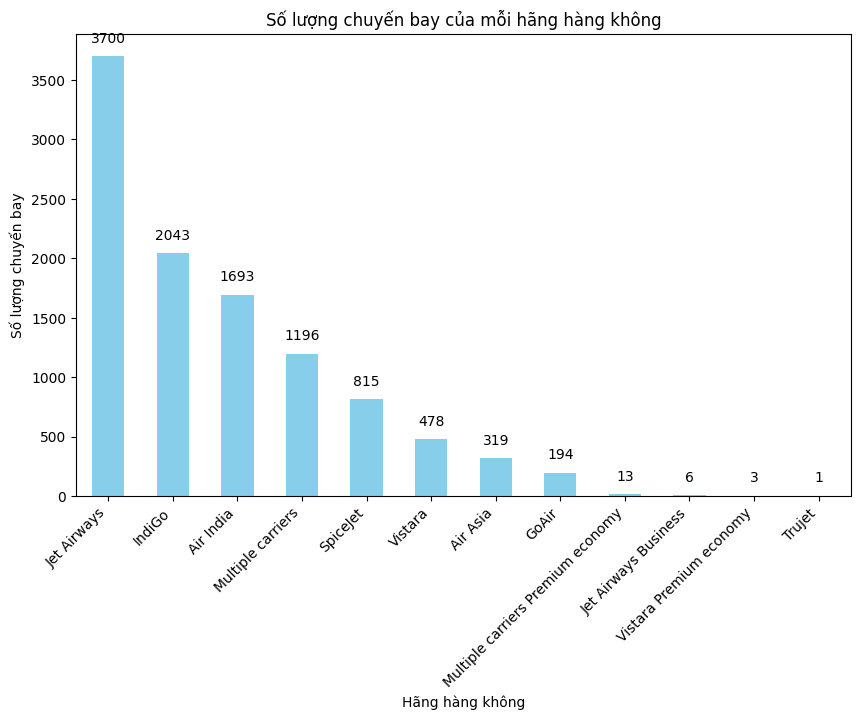

In [282]:
# Đếm số lượng chuyến bay của từng hãng hàng không
airline_counts = merged_data['Airline'].value_counts()

# Vẽ đồ thị cột
plt.figure(figsize=(10, 6))
ax = airline_counts.plot(kind='bar', color='skyblue')

# Thêm số lượng chuyến bay trên đầu mỗi cột
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', xytext=(0, 10), textcoords='offset points')

# Đặt tên hãng máy bay chéo 45 độ
plt.xticks(rotation=45, ha='right')

plt.title('Số lượng chuyến bay của mỗi hãng hàng không')
plt.xlabel('Hãng hàng không')
plt.ylabel('Số lượng chuyến bay')
plt.show()

### 4.2. Kết luận
#### - Dựa vào thông tin datasets cung cấp thì không thể biết được hãng nào được khách đặt nhiều nhất, hay ít nhất; ví dụ: Hãng Jet Airways có 3700 chuyến nhưng mỗi chuyến chỉ có 50 khách đặt-> tổng là 185.000, còn hãng IndiGo có 2043 nhưng mỗi chuyến có 100 khách đăt -> tổng là 204300 lượt khách, mà 204300> 185000, nên IndiGo có lượng khách đặt nhiều hơn Jet Airways dù IndiGo có ít chuyến bay hơn. **Như vậy, với datasets được cung cấp và qua số lượng chuyến bay của mỗi hãng, thì không thể kết luận được hãng nào nhiều/ít khách đặt nhất. Cần có thêm 1 cột Số lượng hành khách mỗi chuyến bay thì ta mới có thể xác định được.**
#### -  Với trường hợp, số lượng khách đặt mỗi chuyến là như nhau (hay chênh lệch không đáng kể), thì hãng Jet Airways có nhiều khách đặt nhất và Trujet có ít khách đặt nhất


## 5. Tháng nào là tháng cao điểm

### 5.1. Visualize: Bởi vì cần đưa ra sự so sánh giữa các nhóm (các tháng) nên chọn biểu đồ là trực quan hơn, giúp người xem dễ hiểu hơn. Vì dữ liệu có ít nhóm (chỉ có số liệu của 4 tháng trong năm 2019) và để so sánh các giá trị giữa các nhóm khác nhau thì chọn biểu đồ cột là hợp lý.

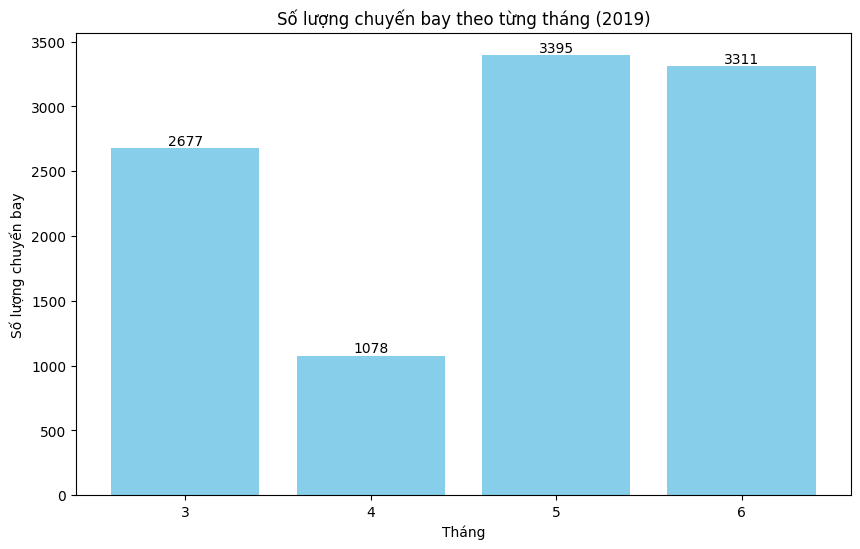

In [283]:
# Đếm số lượng chuyến bay của từng tháng
monthly_flight_counts = merged_data['Month'].value_counts().sort_index()

# Vẽ đồ thị cột
plt.figure(figsize=(10, 6))
bars = plt.bar(monthly_flight_counts.index, monthly_flight_counts, color='skyblue')

# Thêm chú thích (annotation) trên đỉnh mỗi cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, int(yval), int(yval), ha='center', va='bottom')

# Xoay số tháng thẳng lên
plt.xticks(rotation=0)

# Chỉ hiển thị các tháng duy nhất trên trục x
plt.xticks(monthly_flight_counts.index)

plt.title('Số lượng chuyến bay theo từng tháng (2019)')
plt.xlabel('Tháng')
plt.ylabel('Số lượng chuyến bay')
plt.show()

### 5.2. Kết luận
#### Tháng 5 và tháng 6 là 2 tháng số lượng chuyến bay nhiều nhất (số lượng tháng 6 xấp xỉ tháng tháng 5). Như vậy có thể đưa ra kết luận, tháng 5 là tháng cao điểm.


## 6. Giá có thay đổi tùy theo hãng hàng không hay không?

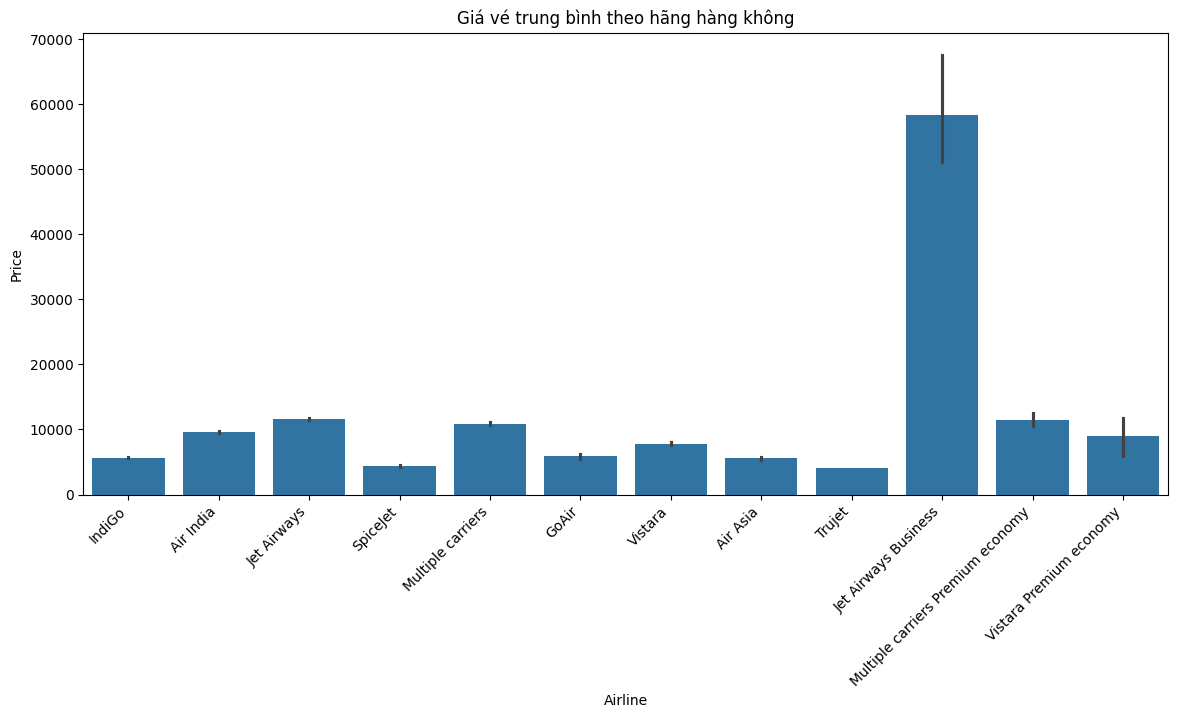

In [284]:
avg_price_by_airline = merged_data.groupby('Airline')['Price'].mean().sort_values()
plt.figure(figsize=(14, 6))
sns.barplot(x='Airline', y='Price', data=merged_data)
plt.xticks(rotation=45, ha='right')
plt.title('Giá vé trung bình theo hãng hàng không')
plt.show()


## 7. Giá vé bị ảnh hưởng như thế nào khi mua vé chỉ 1 hoặc 2 ngày trước ngày khởi hành?

## So sánh giá vé các ngày trong tháng với source và des nhất định

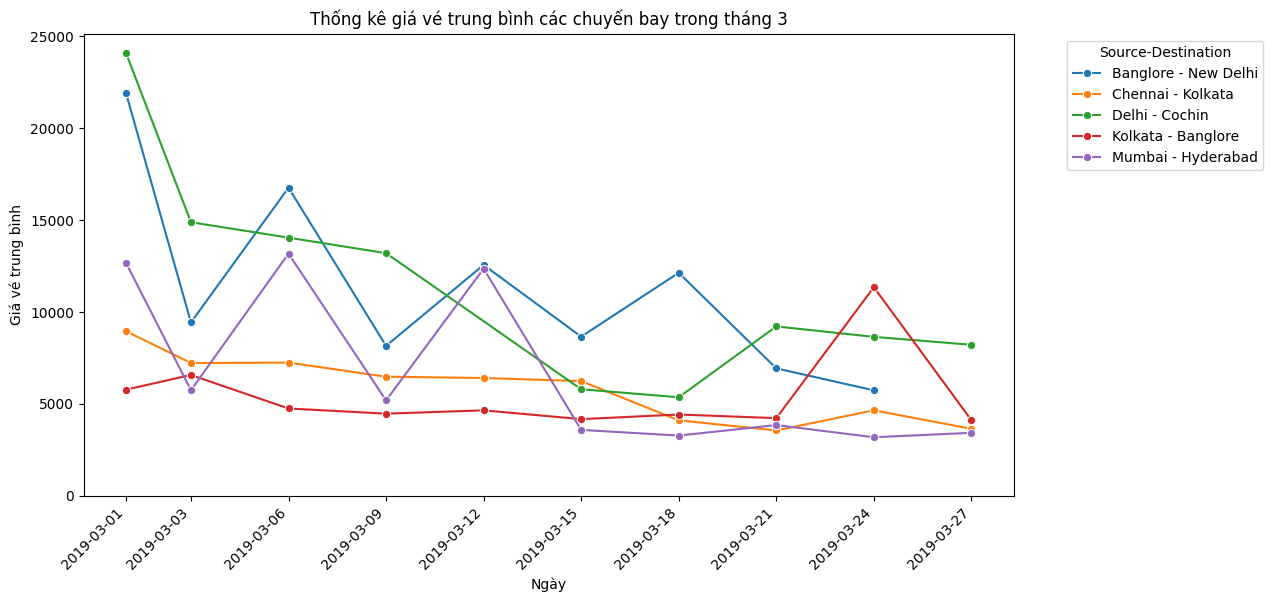

In [285]:

# Assuming you have a sorted list of unique months
#unique_month_sorted = merged_data['Month'].sort_values().unique()

month = 3
# Loop through each month to create a line plot
#for month in unique_month_sorted:
    # Filter data for the current month
data_month = merged_data[merged_data['Month'] == month]
    
# Group by source, destination, and date to calculate average price for each pair over time
average_price = data_month.groupby(['Source', 'Destination', 'Date_of_Journey'])['Price'].mean().reset_index()

plt.figure(figsize=(12, 6))
# Concatenate 'Source' and 'Destination' to create a new column
average_price['Source-Destination'] = average_price['Source'] + ' - ' + average_price['Destination']

# Use Seaborn's lineplot to plot the average price over time for each source-destination pair
sns.lineplot(x='Date_of_Journey', y='Price', hue='Source-Destination', data=average_price,marker='o')

plt.ylim(0)
plt.xlabel('Ngày')
plt.ylabel('Giá vé trung bình')
plt.title(f'Thống kê giá vé trung bình các chuyến bay trong tháng {month}')
plt.xticks(data_month['Date_of_Journey'].unique(), rotation=45, ha='right')
plt.legend(title='Source-Destination', bbox_to_anchor=(1.05, 1), loc='upper left')
    
plt.show()


**Kết luận:**

- Giá vé chuyến bay tháng 3:
	+ Chennai - Kolkata không có sự chênh lệch lớn.
	+ Delhi - Cochin giá ngày 1 cao hơn ~gấp đôi so mặt bằng chung, trong khi ngày 15, 18 thì thấp hơn.
	+ Banglore - New Delhi giá vé có sự lên xuống giữa các ngày gần nhau, riêng giá ngày 1 cao hơn.
	+ Mumbai - Hyderabad: Đầu tháng giá vé có sự chênh lệch, về cuối tháng thấp hơn so với mặt bằng chung.
	+ Kolkata - Banglore: ngày 24 giá vé cao hơn so với cả tháng.
- Giá vé chuyến bay tháng 4:
	+ Delhi - Cochin giá ngày 9 cao hơn so với cả tháng.
	+ Banglore - New Delhi không có sự chênh lệch lớn.
	+ Mumbai - Hyderabad: không có sự chênh lệch lớn.
	+ Kolkata - Banglore: ngày 1 giá vé cao hơn so với cả tháng.
- Giá vé chuyến bay tháng 5:
	+ Chennai - Kolkata, Banglore - Delhi, Mumbai - Hyderabad không có sự chênh lệch lớn.
	+ Delhi - Cochin: giá cả tháng cao, riêng ngày 12 thấp. 
	+ Kolkata - Banglore: giá cả tháng cao, riêng ngày 3, 27 thấp.
- Giá vé chuyến bay tháng 6:
	+ Chennai - Kolkata, Banglore - Delhi, Mumbai - Hyderabad không có sự chênh lệch lớn.
	+ Delhi - Cochin: giá cả tháng cao, riêng ngày 18, 21 thấp. 
	+ Kolkata - Banglore: giá ngày 6, 9, 12 cao. 
    
**Vậy giá vé có sự chênh lệch giữa các ngày và các địa điểm đi và đến trong tháng**
 


## 8. Giá vé có thay đổi theo thời gian đi và đến không?

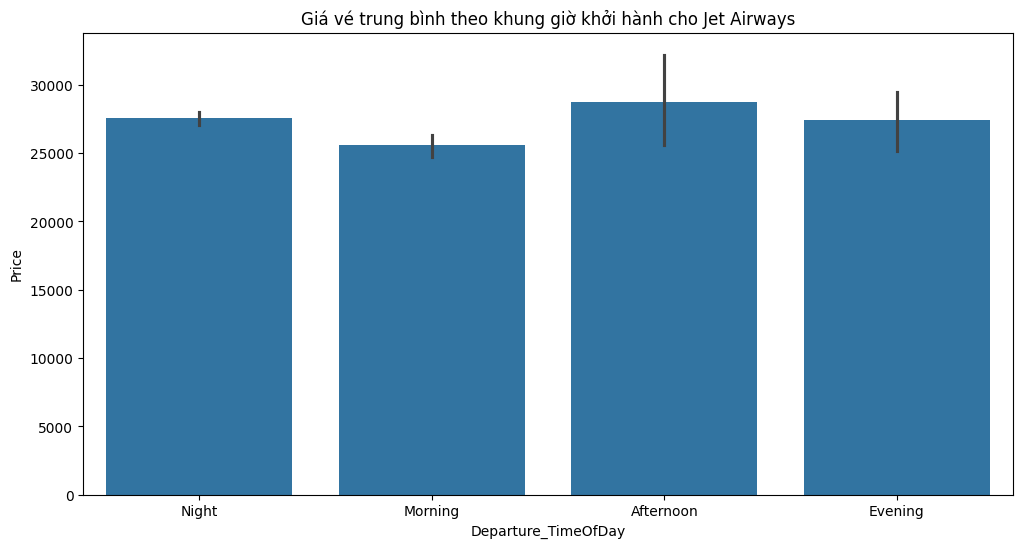

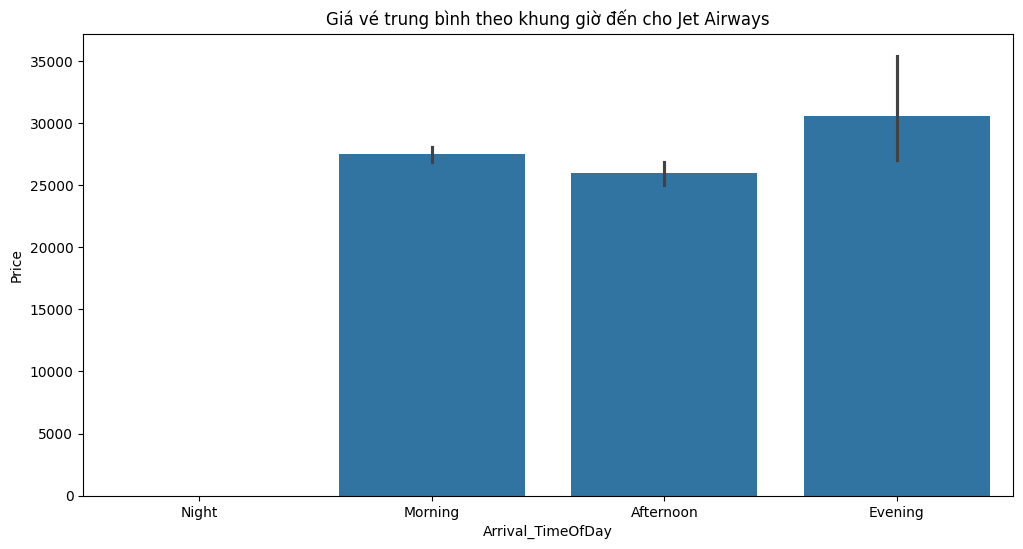

In [286]:
# ReplReplace 'Jet Airways' with the desired airline
airline = 'Jet Airways'
# Replace '01/05/2019' with the specific date you want to filter
specific_date = '01/03/2019'
specific_date = pd.to_datetime(specific_date, format='%d/%m/%Y')

source = 'Banglore'
des = 'New Delhi'
merged_data['Departure_Hour'] = pd.to_datetime(merged_data['Dep_Time'], format='%H:%M').dt.hour

# Create a new column for the time of day
merged_data['Departure_TimeOfDay'] = pd.cut(merged_data['Departure_Hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'])
# Filter data for the specific airline and specific date
filtered_data = merged_data[(merged_data['Airline'] == airline) & (merged_data['Date_of_Journey'] == specific_date) & (merged_data['Source'] == source)
                     & (merged_data['Destination'] == des)]

# Biểu đồ giá vé trung bình theo khung giờ khởi hành
plt.figure(figsize=(12, 6))
sns.barplot(x='Departure_TimeOfDay', y='Price', data=filtered_data)
plt.title(f'Giá vé trung bình theo khung giờ khởi hành cho {airline}')
plt.show()

# Convert Arrival_Time to datetime
merged_data['Arrival_Hour'] = pd.to_datetime(merged_data['Arrival_Time'], format='%H:%M').dt.hour

# Create a new column for the time of day for arrival
merged_data['Arrival_TimeOfDay'] = pd.cut(merged_data['Arrival_Hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'])

# Filter data for the specific airline and specific date
filtered_data_arrival = merged_data[(merged_data['Airline'] == airline) & (merged_data['Arrival_Date'] == specific_date) & (merged_data['Source'] == source)
                              & (merged_data['Destination'] == des)]

#Biểu đồ giá vé trung bình theo khung giờ đến
plt.figure(figsize=(12, 6))
sns.barplot(x='Arrival_TimeOfDay', y='Price', data=filtered_data_arrival)
plt.title(f'Giá vé trung bình theo khung giờ đến cho {airline}')
plt.show()


## 9. Giá thay đổi như thế nào khi thay đổi Nguồn và Điểm đến?

## 10. So sánh giá, số chuyến bay, số điểm dừng giữa weekend và weekday của các hãng máy bay

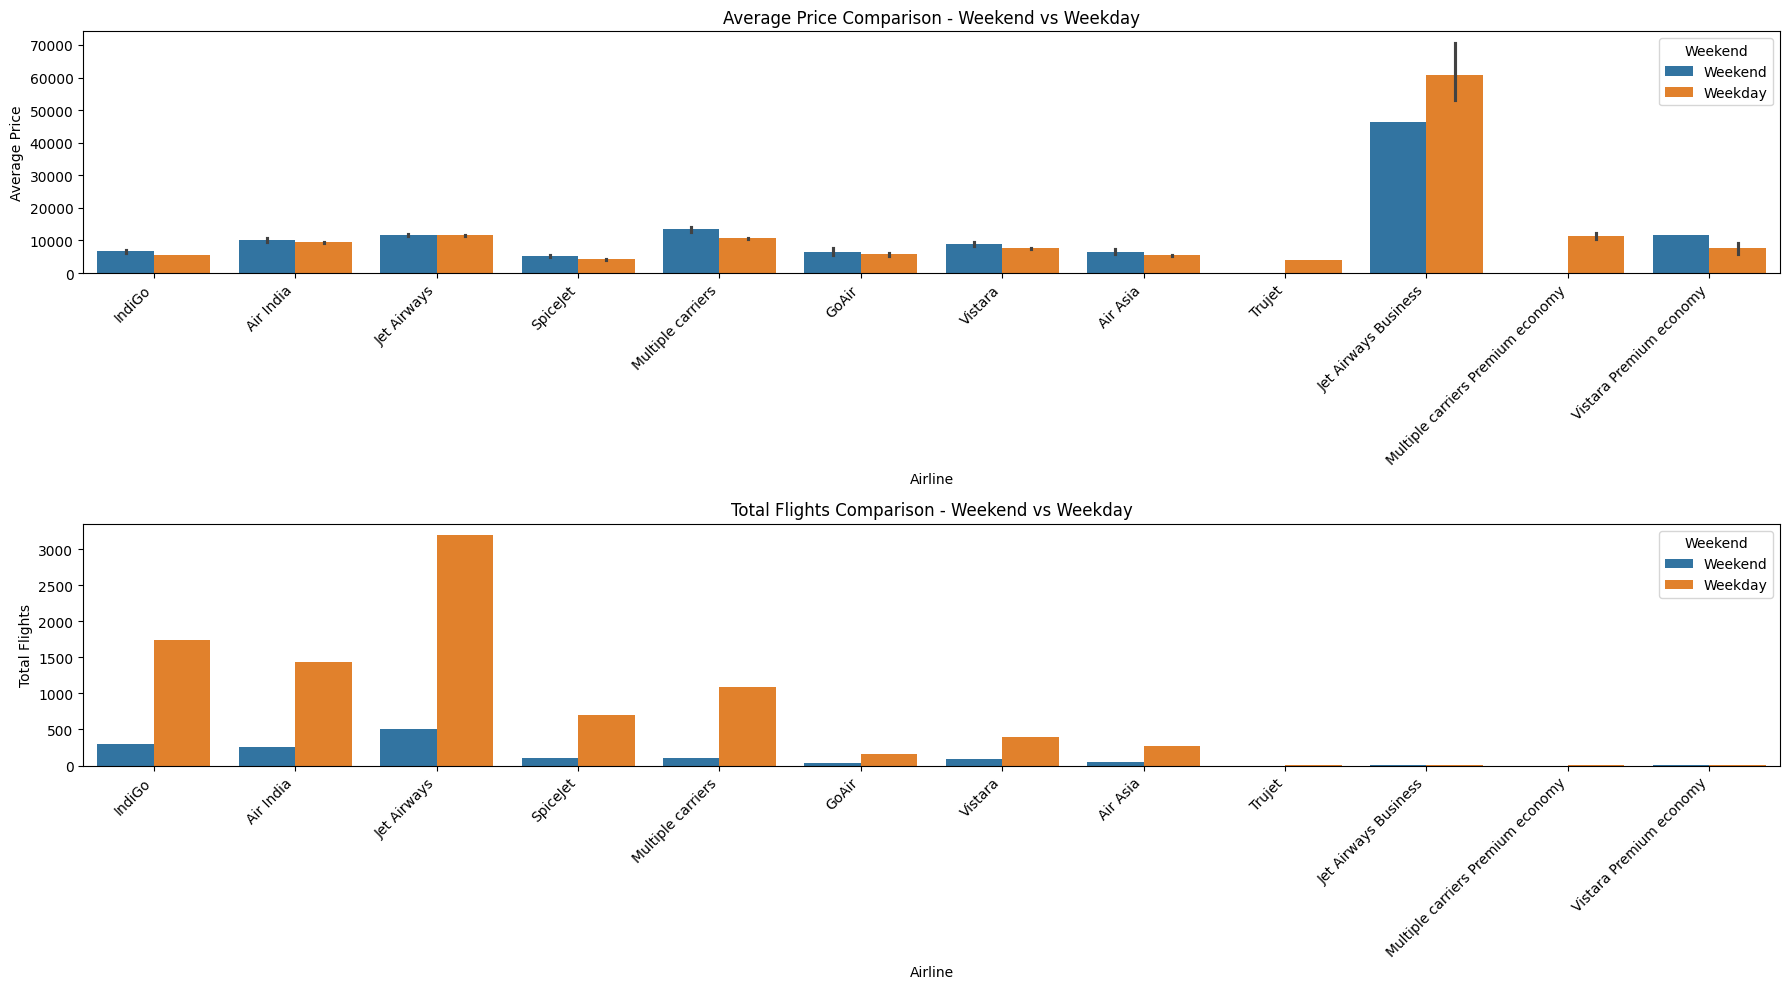

In [287]:
# Tạo biến mới "DayType" để xác định ngày thuộc weekend hay ngày thường
day_type = merged_data['Weekend'].apply(lambda x: 'Weekend' if x == 1 else 'Weekday')

# Thiết lập kích thước đồ thị
plt.figure(figsize=(18, 10))

# Vẽ biểu đồ giá trung bình theo hãng và ngày
plt.subplot(2, 1, 1)
sns.barplot(x='Airline', y='Price', hue=day_type, data=merged_data)
plt.title('Average Price Comparison - Weekend vs Weekday')
plt.ylabel('Average Price')
plt.xticks(rotation=45, ha='right')

# Vẽ biểu đồ số điểm dừng theo hãng và ngày
# plt.subplot(2, 1, 2)
# sns.barplot(x='Airline', y='Total_Stops', hue=day_type, data=merged_data, estimator=sum)
# plt.title('Total Stops Comparison - Weekend vs Weekday')
# plt.ylabel('Total Stops')
# plt.xticks(rotation=45, ha='right')

# Vẽ biểu đồ số chuyến bay theo hãng và ngày
plt.subplot(2, 1, 2)

sns.countplot(x='Airline', hue=day_type, data=merged_data)
plt.title('Total Flights Comparison - Weekend vs Weekday')
plt.ylabel('Total Flights')
plt.xticks(rotation=45, ha='right')

# Tăng khoảng cách giữa các đồ thị
plt.tight_layout()

# Hiển thị đồ thị
plt.show()

## 11. So sánh giá, số chuyến bay và số điểm dừng giữa các tháng theo hãng

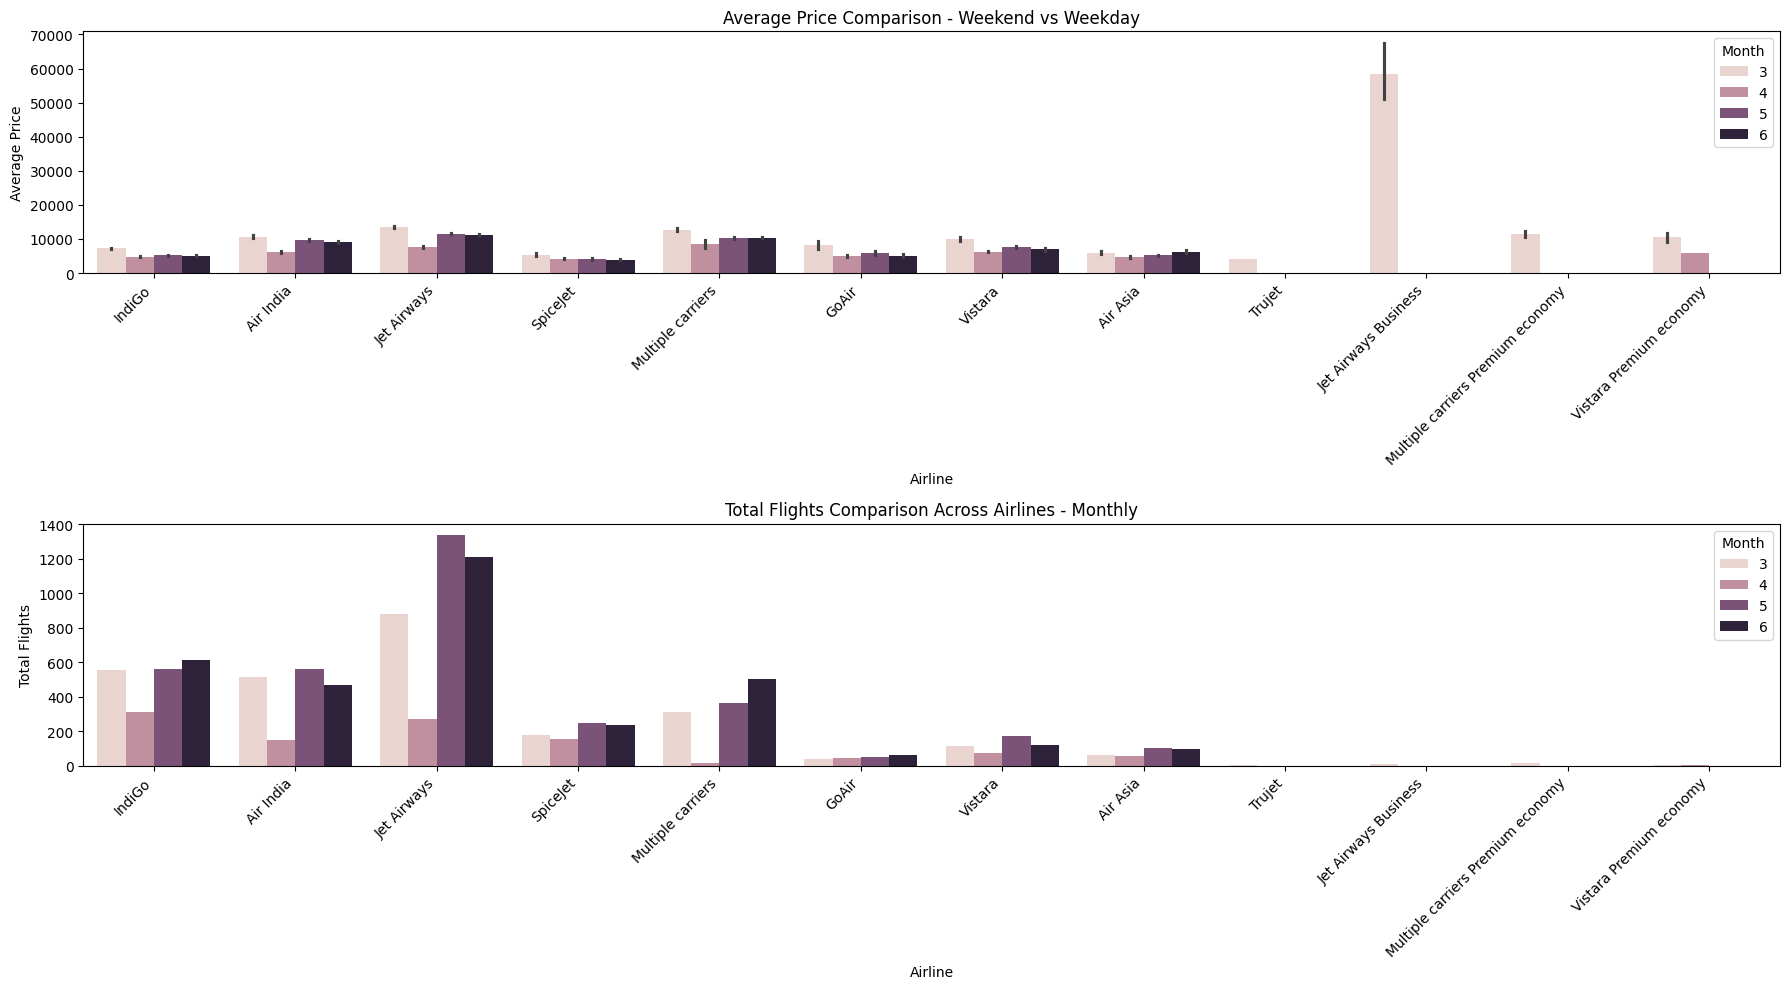

In [288]:
# Thiết lập kích thước đồ thị
plt.figure(figsize=(18, 10))

# Vẽ biểu đồ giá trung bình theo hãng và tháng

plt.subplot(2, 1, 1)
sns.barplot(x='Airline', y='Price', hue='Month', data=merged_data)
plt.title('Average Price Comparison - Weekend vs Weekday')
plt.ylabel('Average Price')
plt.xticks(rotation=45, ha='right')

# Vẽ biểu đồ số điểm dừng theo hãng và tháng
# plt.subplot(2, 1, 2)
# sns.barplot(x='Airline', y='Total_Stops', hue='Month', data=merged_data, estimator=sum)
# plt.title('Total Stops Comparison Across Airlines - Monthly')
# plt.ylabel('Total Stops')
# plt.xticks(rotation=45, ha='right')

# Vẽ biểu đồ số chuyến bay theo hãng và tháng
plt.subplot(2, 1, 2)

sns.countplot(x='Airline', hue='Month', data=merged_data)
plt.title('Total Flights Comparison Across Airlines - Monthly')
plt.ylabel('Total Flights')
plt.xticks(rotation=45, ha='right')
# Tăng khoảng cách giữa các đồ thị
plt.tight_layout()

# Hiển thị đồ thị
plt.show()

## 12. Giá theo info tổng quát

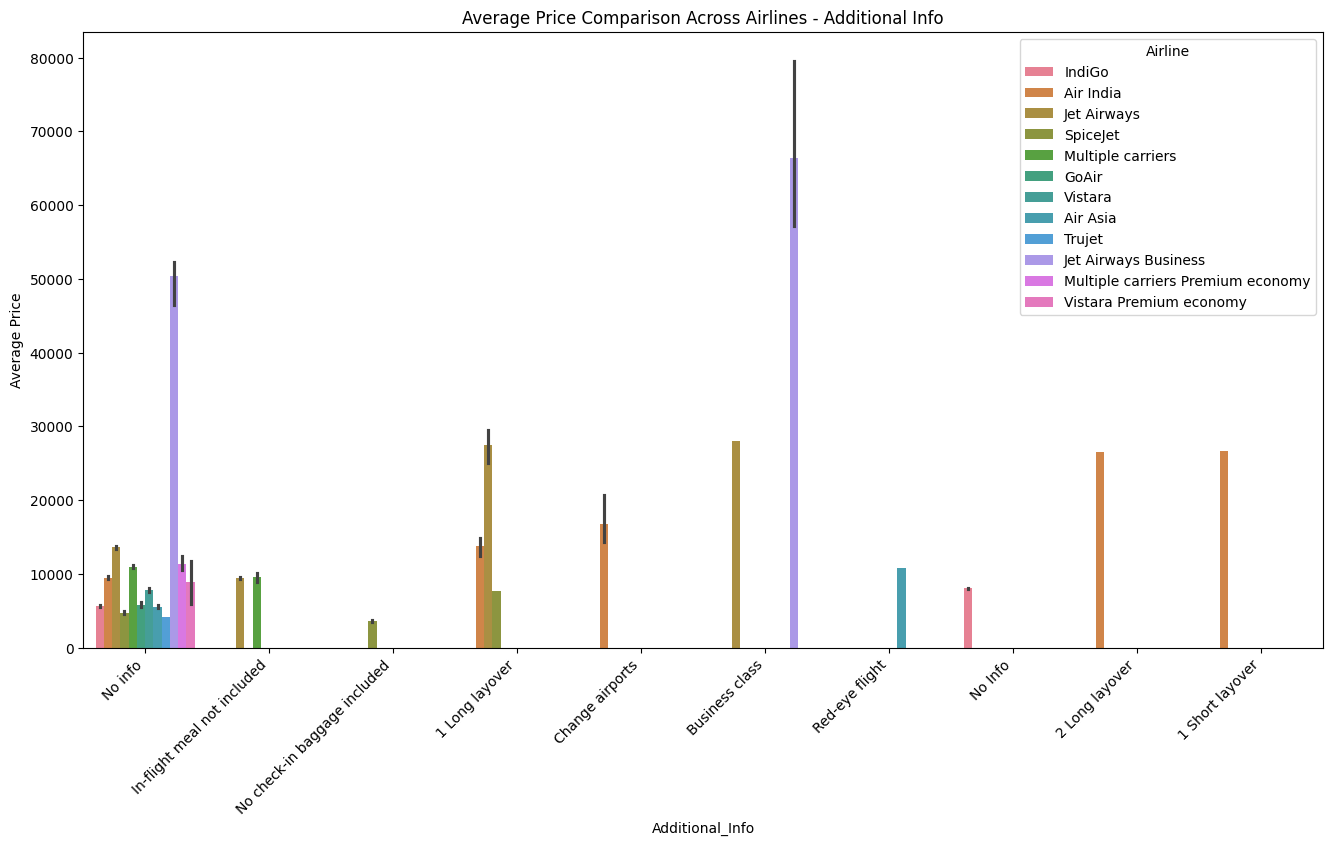

In [289]:
# Thiết lập kích thước đồ thị
plt.figure(figsize=(16, 8))

# Vẽ biểu đồ giá trung bình theo Additional_info và hãng
sns.barplot(x='Additional_Info', y='Price', hue='Airline', data=merged_data)
plt.title('Average Price Comparison Across Airlines - Additional Info')
plt.ylabel('Average Price')
plt.xticks(rotation=45, ha='right')

# Hiển thị đồ thị
plt.show()

Theo ngày, điểm đi, điểm đến

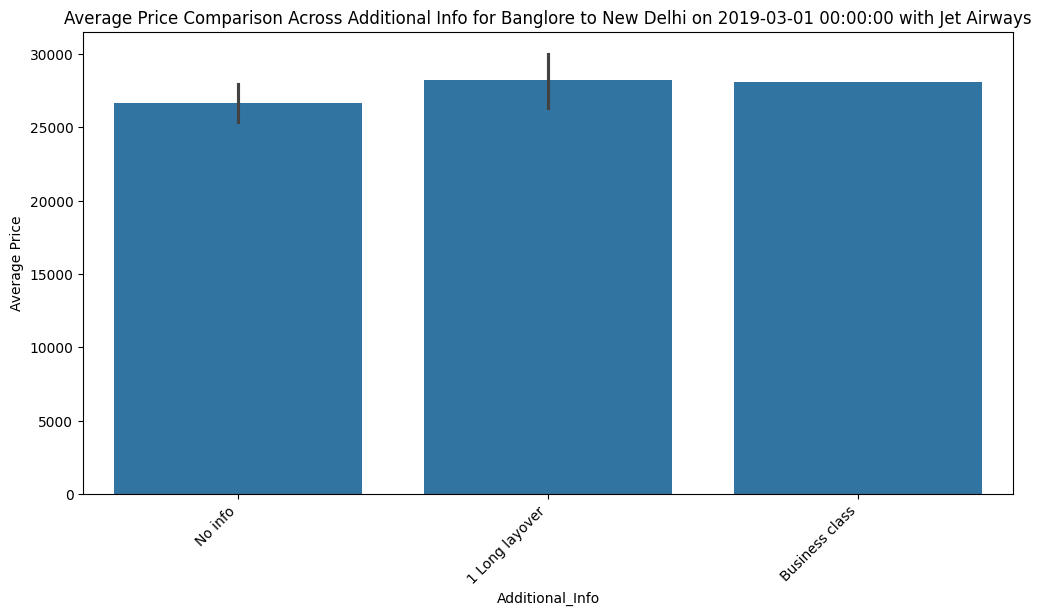

In [290]:
# Chọn một ngày, một điểm đi và một điểm đến cụ thể
selected_date = '01/03/2019'  # Đổi thành ngày mong muốn
selected_source = 'Banglore'     # Đổi thành điểm đi mong muốn
selected_destination = 'New Delhi'  # Đổi thành điểm đến mong muốn
selected_date=pd.to_datetime(selected_date, format='%d/%m/%Y')
selected_airline = 'Jet Airways'
# Lọc dữ liệu cho các điều kiện được chọn
selected_data = merged_data[(merged_data['Date_of_Journey'] == selected_date) &
                   (merged_data['Source'] == selected_source) &
                   (merged_data['Destination'] == selected_destination)&
                   (merged_data['Airline'] == selected_airline)]

# Kiểm tra xem DataFrame có trống không
if not selected_data.empty:
    # Thiết lập kích thước đồ thị
    plt.figure(figsize=(12, 6))

    # Vẽ biểu đồ giá trung bình theo Additional_Info
    sns.barplot(x='Additional_Info', y='Price', data=selected_data)
    plt.title(f'Average Price Comparison Across Additional Info for {selected_source} to {selected_destination} on {selected_date} with {selected_airline}')
    plt.ylabel('Average Price')
    plt.xticks(rotation=45, ha='right')

    # Hiển thị đồ thị
    plt.show()
else:
    print("No data found for the selected conditions.")

# Kết luận các điểm chính quan sát được từ dữ liệu từ các gợi ý trên


# Ngoài các đặc trưng trong tập dữ liệu, các yếu tố nào có khả năng ảnh hưởng đến giá vé chuyến bay?



# Dự đoán giá vé

In [291]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
# Build the Regression / Regressor models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics

In [292]:
# Stastical Description of Data
# Tạo DataFrame
df = pd.DataFrame(merged_data)
# Creating a Back up File
df_bk=df.copy()
#df.info()

In [293]:
#Vì có sẵn month nên thêm day để bỏ date_of_journey
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'])
# Extract day and create a new column
df['Day'] = df['Date_of_Journey'].dt.day

In [294]:
def drop_useless_col(df, cols):
    df.drop(columns=cols, axis=1, inplace=True)
    return df
#Bỏ Duration vì đã có arrival_time
#Bỏ date_of journey vì đã có day, month, year là 2019 nên không tính
#
df = drop_useless_col(df, [ 'Route', 'Duration', 'Date_of_Journey', 'Arrival_Date', 'Departure_TimeOfDay','Arrival_TimeOfDay', 'Departure_Hour','Arrival_Hour'])
df.head()

,Airline,Source,Destination,Dep_Time,Arrival_Time,Total_Stops,Additional_Info,Price,Month,WeekDay,Weekend,Day
0,IndiGo,Banglore,New Delhi,22:20,01:10,0.0,No info,3897,3,Sunday,1,24
1,Air India,Kolkata,Banglore,05:50,13:15,2.0,No info,7662,5,Wednesday,0,1
2,Jet Airways,Delhi,Cochin,09:25,04:25,2.0,No info,13882,6,Sunday,1,9
3,IndiGo,Kolkata,Banglore,18:05,23:30,1.0,No info,6218,5,Sunday,1,12
4,IndiGo,Banglore,New Delhi,16:50,21:35,1.0,No info,13302,3,Friday,0,1


In [295]:
# Coverting the labels into a numeric form using Label Encoder
le=LabelEncoder()
for col in df.columns:
    if df[col].dtype=='object':
        df[col]=le.fit_transform(df[col])

df.head()

,Airline,Source,Destination,Dep_Time,Arrival_Time,Total_Stops,Additional_Info,Price,Month,WeekDay,Weekend,Day
0,3,0,5,211,12,0,8,3897,3,3,1,24
1,1,3,0,31,104,2,8,7662,5,6,0,1
2,4,2,1,70,30,2,8,13882,6,3,1,9
3,3,3,0,164,217,1,8,6218,5,3,1,12
4,3,0,5,149,194,1,8,13302,3,0,0,1


In [296]:
# storing the Dependent Variables in X and Independent Variable in Y
x = df.drop(axis=1, columns=['Price'])
y = df['Price']

In [297]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((8368, 11), (2093, 11), (8368,), (2093,))

In [298]:
#mmscaler=MinMaxScaler(feature_range=(0,1))
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.fit_transform(x_test)
x_train=pd.DataFrame(x_train)
x_test=pd.DataFrame(x_test)  

In [299]:
# Create objects of Regression / Regressor models with default hyper-parameters

modelmlg = LinearRegression()
modeldcr = DecisionTreeRegressor()
modelbag = BaggingRegressor()
modelrfr = RandomForestRegressor()
modelSVR = SVR()
modelXGR = xgb.XGBRegressor()
modelKNN = KNeighborsRegressor(n_neighbors=5)
modelETR = ExtraTreesRegressor()
modelRE=Ridge()
modelLO=linear_model.Lasso(alpha=0.1)

modelGBR = GradientBoostingRegressor(loss='squared_error', learning_rate=0.1, n_estimators=100, subsample=1.0,
                                     criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1,
                                     min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0,
                                     init=None, random_state=None, max_features=None,
                                     alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False,
                                     validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)

# Evalution matrix for all the algorithms

MM = [modelmlg, modeldcr, modelrfr, modelKNN, modelETR, modelGBR, modelXGR, modelbag,modelRE,modelLO]

# Initialize an empty DataFrame
a = {'Model Name': [], 'Mean_Absolute_Error_MAE': [], 'Adj_R_Square': [],
     'Root_Mean_Squared_Error_RMSE': [], 'Mean_Absolute_Percentage_Error_MAPE': [],
     'Mean_Squared_Error_MSE': [], 'Root_Mean_Squared_Log_Error_RMSLE': [], 'R2_score': []}
Results = pd.DataFrame(a)
results_list = []
for model in MM:
    # Fit the model with train data
    model.fit(x_train, y_train)

    # Predict the model with test data
    y_pred = model.predict(x_test)
    # Print the model name
    print('Model Name:', type(model).__name__)

    # Evaluation metrics for Regression analysis
    print('Mean Absolute Error (MAE):', round(metrics.mean_absolute_error(y_test, y_pred), 3))
    print('Mean Squared Error (MSE):', round(metrics.mean_squared_error(y_test, y_pred), 3))
    print('Root Mean Squared Error (RMSE):', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 3))
    print('R2_score:', round(metrics.r2_score(y_test, y_pred), 6))
    print('Root Mean Squared Log Error (RMSLE):',
          round(np.log(np.sqrt(metrics.mean_squared_error(y_test, y_pred))), 3))

    # Evaluation of MAPE
    def MAPE(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    result = MAPE(y_test, y_pred)
    print('Mean Absolute Percentage Error (MAPE):', round(result, 2), '%')

    # Calculate Adjusted R squared values
    r_squared = round(metrics.r2_score(y_test, y_pred), 6)
    adjusted_r_squared = round(1 - (1 - r_squared) * (len(y_test) - 1) / (len(y_test) - x_test.shape[1] - 1), 6)
    print('Adj R Square:', adjusted_r_squared)
    print('------------------------------------------------------------------------------------------------------------')

    # Append results to the Results DataFrame
    new_row = {'Model Name': type(model).__name__,
               'Mean_Absolute_Error_MAE': round(metrics.mean_absolute_error(y_test, y_pred), 3),
               'Adj_R_Square': adjusted_r_squared,
               'Root_Mean_Squared_Error_RMSE': round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 3),
               'Mean_Absolute_Percentage_Error_MAPE': round(result, 2),
               'Mean_Squared_Error_MSE': round(metrics.mean_squared_error(y_test, y_pred), 3),
               'Root_Mean_Squared_Log_Error_RMSLE': round(np.log(np.sqrt(metrics.mean_squared_error(y_test, y_pred))), 3),
               'R2_score': round(metrics.r2_score(y_test, y_pred), 6)}

    results_list.append(new_row)

# Create a DataFrame from the results_list
Results = pd.DataFrame(results_list)


Model Name: LinearRegression
Mean Absolute Error (MAE): 2512.896
Mean Squared Error (MSE): 12642287.582
Root Mean Squared Error (RMSE): 3555.599
R2_score: 0.429167
Root Mean Squared Log Error (RMSLE): 8.176
Mean Absolute Percentage Error (MAPE): 32.28 %
Adj R Square: 0.42615
------------------------------------------------------------------------------------------------------------
Model Name: DecisionTreeRegressor
Mean Absolute Error (MAE): 820.903
Mean Squared Error (MSE): 4116291.649
Root Mean Squared Error (RMSE): 2028.865
R2_score: 0.814138
Root Mean Squared Log Error (RMSLE): 7.615
Mean Absolute Percentage Error (MAPE): 8.97 %
Adj R Square: 0.813156
------------------------------------------------------------------------------------------------------------


Model Name: RandomForestRegressor
Mean Absolute Error (MAE): 725.945
Mean Squared Error (MSE): 2778740.792
Root Mean Squared Error (RMSE): 1666.956
R2_score: 0.874532
Root Mean Squared Log Error (RMSLE): 7.419
Mean Absolute Percentage Error (MAPE): 8.03 %
Adj R Square: 0.873869
------------------------------------------------------------------------------------------------------------
Model Name: KNeighborsRegressor
Mean Absolute Error (MAE): 1463.782
Mean Squared Error (MSE): 6334950.699
Root Mean Squared Error (RMSE): 2516.933
R2_score: 0.71396
Root Mean Squared Log Error (RMSLE): 7.831
Mean Absolute Percentage Error (MAPE): 17.9 %
Adj R Square: 0.712448
------------------------------------------------------------------------------------------------------------
Model Name: ExtraTreesRegressor
Mean Absolute Error (MAE): 827.624
Mean Squared Error (MSE): 3058185.362
Root Mean Squared Error (RMSE): 1748.767
R2_score: 0.861915
Root Mean Squared Log Error (RMSLE): 7.467
Mean Absolute Perc

In [300]:
models=['LinearRegression','DecisionTreeRegressor','RandomForestRegressor','KNeighborsRegressor','ExtraTreesRegressor','GradientBoostingRegressor','XGBRegressor','BaggingRegressor','Ridge Regression','Lasso Regression']
result=pd.DataFrame({'Model_Name':models})
result['Adj_R_Square']=Results['Adj_R_Square']
result['Mean_Absolute_Error_MAE']=Results['Mean_Absolute_Error_MAE']
result['Root_Mean_Squared_Error_RMSE']=Results['Root_Mean_Squared_Error_RMSE']
result['Mean_Absolute_Percentage_Error_MAPE']=Results['Mean_Absolute_Percentage_Error_MAPE']
result['Mean_Squared_Error_MSE']=Results['Mean_Squared_Error_MSE']
result['Root_Mean_Squared_Log_Error_RMSLE']=Results['Root_Mean_Squared_Log_Error_RMSLE']
result['R2_score']=Results['R2_score']
result=result.sort_values(by='Adj_R_Square',ascending=False).reset_index(drop=True)
result

,Model_Name,Adj_R_Square,Mean_Absolute_Error_MAE,Root_Mean_Squared_Error_RMSE,Mean_Absolute_Percentage_Error_MAPE,Mean_Squared_Error_MSE,Root_Mean_Squared_Log_Error_RMSLE,R2_score
0,RandomForestRegressor,0.873869,725.945,1666.956,8.03,2.778741e+06,7.419,0.874532
1,BaggingRegressor,0.862053,756.851,1743.294,8.34,3.039073e+06,7.464,0.862778
2,ExtraTreesRegressor,0.861185,827.624,1748.767,8.71,3.058185e+06,7.467,0.861915
3,DecisionTreeRegressor,0.813156,820.903,2028.865,8.97,4.116292e+06,7.615,0.814138
4,GradientBoostingRegressor,0.796784,1304.811,2115.885,15.48,4.476970e+06,7.657,0.797853
5,KNeighborsRegressor,0.712448,1463.782,2516.933,17.90,6.334951e+06,7.831,0.713960
6,LinearRegression,0.426150,2512.896,3555.599,32.28,1.264229e+07,8.176,0.429167
7,Lasso Regression,0.426148,2512.877,3555.606,32.28,1.264233e+07,8.176,0.429165
8,Ridge Regression,0.426144,2512.903,3555.616,32.28,1.264240e+07,8.176,0.429161
9,XGBRegressor,-0.824316,4328.882,6339.623,43.98,4.019082e+07,8.755,-0.814724


In [301]:
#Trainig the model with
model = modelrfr.fit(x_train, y_train)
# Predict the model with test data
y_pred = model.predict(x_test)
out=pd.DataFrame({'Price_actual':y_test,'Price_pred':y_pred})
result=df_bk.merge(out,left_index=True,right_index=True)
result.sample(10)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,...,Month,WeekDay,Weekend,Arrival_Date,Departure_Hour,Departure_TimeOfDay,Arrival_Hour,Arrival_TimeOfDay,Price_actual,Price_pred
1368,Jet Airways,2019-06-01,Banglore,Delhi,BLR → DEL,18:55,22:00,185,0.0,No info,...,6,Saturday,0,2019-06-01,18,Afternoon,22,Evening,8016,8016.000000
6915,Jet Airways,2019-06-03,Delhi,Cochin,DEL → IDR → BOM → COK,09:35,12:35,1620,2.0,In-flight meal not included,...,6,Monday,0,2019-06-04,9,Morning,12,Morning,11507,11040.098333
10114,SpiceJet,2019-06-09,Banglore,Delhi,BLR → DEL,21:10,00:05,175,0.0,No info,...,6,Sunday,1,2019-06-10,21,Evening,0,NaN,3971,3963.230000
3459,Jet Airways,2019-05-01,Kolkata,Banglore,CCU → BOM → BLR,20:00,04:40,520,1.0,In-flight meal not included,...,5,Wednesday,0,2019-05-02,20,Evening,4,Night,8586,9198.940000
3024,Jet Airways,2019-03-24,Banglore,New Delhi,BLR → BOM → DEL,08:55,09:00,1445,1.0,In-flight meal not included,...,3,Sunday,1,2019-03-25,8,Morning,9,Morning,8147,8956.750000
2935,Jet Airways,2019-05-09,Delhi,Cochin,DEL → BOM → COK,17:30,12:35,1145,1.0,In-flight meal not included,...,5,Thursday,0,2019-05-10,17,Afternoon,12,Morning,12373,12373.000000
5969,SpiceJet,2019-05-18,Kolkata,Banglore,CCU → IXB → BLR,15:55,21:25,330,1.0,No info,...,5,Saturday,0,2019-05-18,15,Afternoon,21,Evening,8224,7978.980000
5712,IndiGo,2019-06-01,Delhi,Cochin,DEL → COK,05:35,08:50,195,0.0,No info,...,6,Saturday,0,2019-06-01,5,Night,8,Morning,6541,5639.280000
7862,Jet Airways,2019-06-06,Delhi,Cochin,DEL → BOM → COK,14:00,19:00,300,1.0,No info,...,6,Thursday,0,2019-06-06,14,Afternoon,19,Evening,14714,14714.000000
4189,Multiple carriers,2019-06-09,Delhi,Cochin,DEL → BOM → COK,04:55,19:00,845,1.0,No info,...,6,Sunday,1,2019-06-09,4,Night,19,Evening,10877,10975.110000


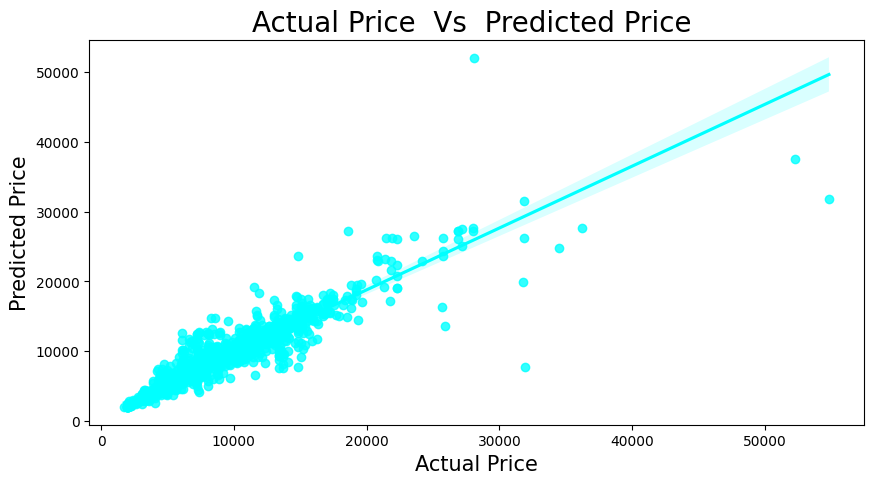

In [302]:
plt.figure(figsize=(10,5))
sns.regplot(x='Price_actual',y='Price_pred',data=result,color='cyan')
plt.title('Actual Price  Vs  Predicted Price ',fontsize=20)
plt.xlabel('Actual Price',fontsize=15)
plt.ylabel('Predicted Price',fontsize=15)
plt.show()

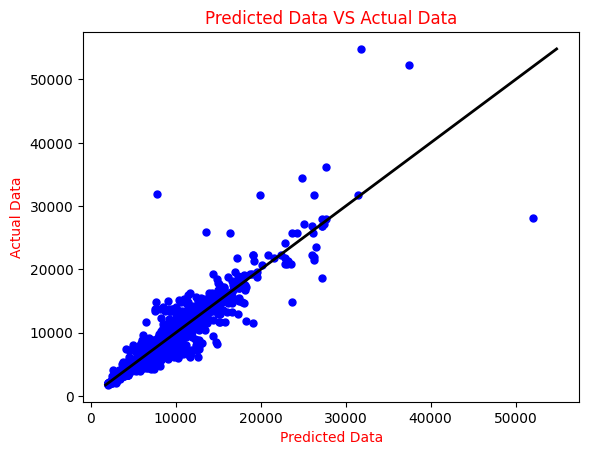

In [303]:
#Plotting the results
plt.scatter(y_pred,y_test,c='blue',marker='o',s=25)
plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()],c='black',lw=2)
plt.xlabel('Predicted Data',c='red')
plt.ylabel('Actual Data',c='red')
plt.title('Predicted Data VS Actual Data',c='red')
plt.show()